In [1]:
import glob 
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Laplace
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

import poisevae
from poisevae.datasets import CUB
from poisevae.utils import NN_lookup, Categorical
from poisevae.networks.CUBNetworks import EncImg, DecImg, EncTxt, DecTxt

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['text.usetex'] = False

In [2]:
HOME_PATH = os.path.expanduser('~')
DATA_PATH = os.path.join(HOME_PATH, 'Datasets/CUB/')

In [6]:
tx = lambda data: torch.Tensor(data)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
CUB_train = CUB(DATA_PATH, DATA_PATH, 'train', device, tx, return_idx=False)
CUB_test = CUB(DATA_PATH, DATA_PATH, 'test', device, tx, return_idx=True)

In [9]:
vocab_size, txt_len = CUB_train.CUBtxt.vocab_size, CUB_train.CUBtxt.max_sequence_length
vocab_size, txt_len

(1590, 32)

In [10]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(CUB_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(CUB_test, batch_size=batch_size, shuffle=True)
len(train_loader), len(test_loader)

(692, 230)

In [11]:
enc_img = EncImg(128).to(device)
dec_img = DecImg(128).to(device)
enc_txt = EncTxt(vocab_size, 128).to(device)
dec_txt = DecTxt(vocab_size, 128).to(device)
    
rec_weights = [1, 1] # [1, 2048/txt_len]
vae = poisevae.POISEVAE([enc_img, enc_txt], [dec_img, dec_txt], likelihoods=[Laplace, Categorical], 
                        latent_dims=[128, (128, 1, 1)], rec_weights=rec_weights).to(device)

In [12]:
# for i in vae.named_parameters():
#     print(i[0])

In [13]:
optimizer = optim.Adam(vae.parameters(), lr=1e-3, amsgrad=True)

In [14]:
from datetime import datetime
PATH = os.path.join('runs/CUB', datetime.now().strftime('%y%m%d%H%M'))
if os.path.exists(PATH):
        raise ValueError

In [15]:
epoch = 0
# try:
#     vae, optimizer, epoch = poisevae.utils.load_checkpoint(vae, optimizer, sorted(glob.glob(PATH + 'train*.pt'))[-1])
# except:
#     pass

In [16]:
writer = SummaryWriter(PATH)

In [17]:
epochs = 50 + epoch
for epoch in tqdm(range(epoch, epochs)):
    poisevae.utils.train(vae, train_loader, optimizer, epoch, writer)
    labels, latent_info = poisevae.utils.test(vae, test_loader, epoch, writer, 
                                              record_idx=(-1,), return_latents=True)
    if (epoch+1) % 10 == 0 and epoch > 0:
        poisevae.utils.save_checkpoint(vae, optimizer, os.path.join(PATH, 'training_%d.pt' % (epoch+1)), epoch+1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [44:28<00:00, 53.37s/it]


In [18]:
writer.flush()
writer.close()

In [19]:
poisevae.utils.save_latent_info(latent_info, PATH)

## Results

In [20]:
# vae, optimizer, epoch = poisevae.utils.load_checkpoint(vae, optimizer, sorted(glob.glob(PATH + 'train*.pt'))[-1])
# epoch

In [21]:
with torch.no_grad():
    for i, (img, txt, idx) in enumerate(test_loader):
        results = vae([img.to(device), txt.to(device)])
        x_rec = results['x_rec']
        x_rec = [x_rec[0].loc, x_rec[1].probs.argmax(dim=1).reshape(x_rec[0].loc.shape[0], -1)]
        dist, idx_h = NN_lookup(x_rec[0], img)
        # dist, idx_h = NN_lookup(results['x_rec'][0], img)
        imgs_h = [CUB_test.CUBimg.dataset[int(idx[j]) // 10][0] for j in idx_h]
        imgs = [CUB_test.CUBimg.dataset[int(j) // 10][0] for j in idx]
        txts = [CUB_test.CUBtxt.data[str(int(j))] for j in idx]
        break

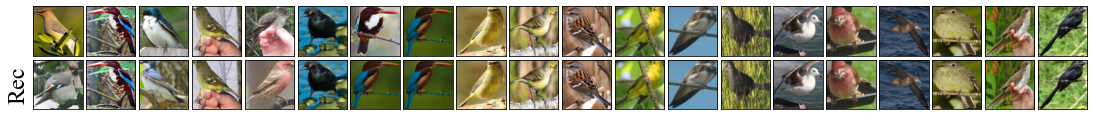

In [22]:
ncols = min(len(imgs_h), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(imgs, imgs_h)):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.permute(1, 2, 0))
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
fig.savefig(os.path.join(PATH, 'CUBImgRec.pdf'), dpi=300)

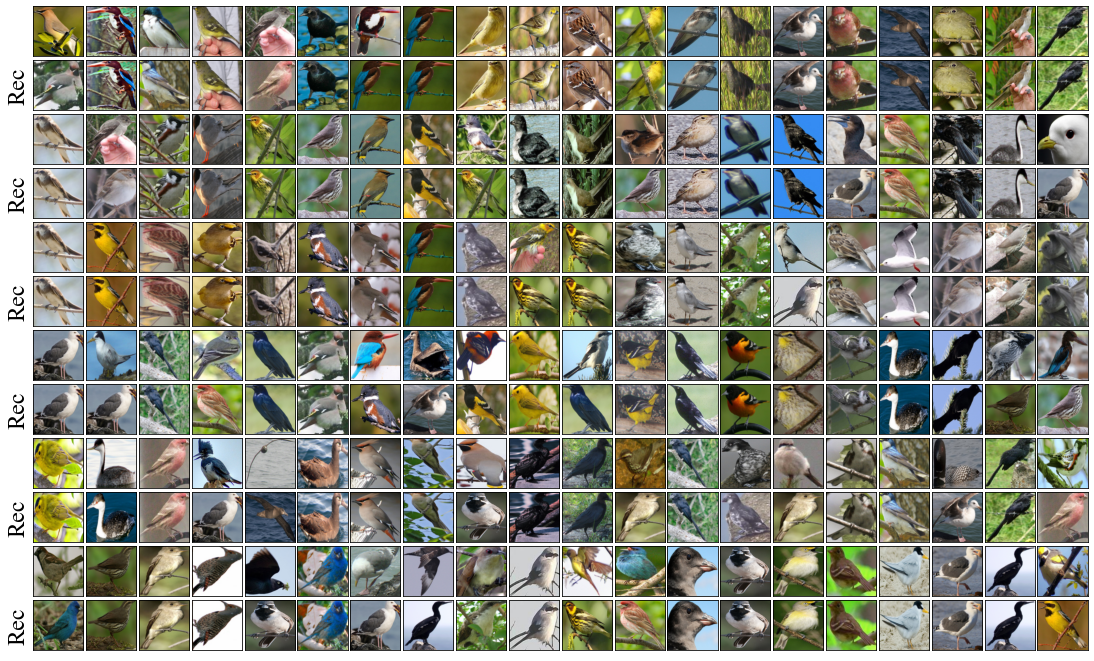

In [23]:
ncols = min(len(imgs_h), 20)
nrows = 2 * int(np.floor(len(imgs_h) / 20))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 1.5*nrows/2))
for i, aux in enumerate(zip(imgs, imgs_h)):
    if i >= nrows / 2 * 20:
        break
    for j, im in enumerate(aux):
        ax[j+i//20*2, i%20].imshow(im.permute(1, 2, 0))
        ax[j+i//20*2, i%20].set_xticks([])
        ax[j+i//20*2, i%20].set_yticks([])
    ax[1+i//20*2, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
fig.savefig(os.path.join(PATH, 'CUBImgRecExtra.pdf'), dpi=300)

In [24]:
sents_h = []
sents_emb = x_rec[1]
for sent_emb in sents_emb:
    sent_h = []
    for j in sent_emb:
        char = CUB_test.CUBtxt.i2w[str(int(j.item()))]
        if char == '<eos>':
            break
        sent_h.append(char)
    sents_h.append(' '.join(sent_h))

sents = []
for i, sent_h in enumerate(sents_h):
    sent = []
    for char in txts[i]['tok']:
        if char == '<eos>':
            break
        sent.append(char)
    sents.append(' '.join(sent))

In [25]:
for sent, sent_h in zip(sents, sents_h):
    print('     ', sent)
    print('Rec: ', sent_h)

      this bird has feathers that are grey and orange and has a black face .
Rec:  this bird has feathers that are grey and orange and has a black face .
      this bird has a long red bill with a dark red crown and blue secondaries .
Rec:  this bird has a long red bill with a dark red crown and blue secondaries .
      the head of the bird is blue while the body is white and the beak is light grey .
Rec:  the head of the bird is blue while the body is white and the beak is light grey .
      this small green bird has a yellow flank and eyering and black tarsus .
Rec:  this small green bird has a yellow flank and eyering and black tarsus .
      this bird has wings that are black and has a small bill .
Rec:  this bird has wings that are black and has a small bill .
      this black bird has a white eye ring and medium , pointed beak .
Rec:  this black bird has a white eye ring and medium , pointed beak .
      this bird has wings that are black and blue with a long red beak .
Rec:  thi

In [26]:
with open(os.path.join(PATH, 'CUBTxtRec.txt'), 'w') as file:
    for sent, sent_h in zip(sents, sents_h):
        file.write('Ref: ' + sent + '\n')
        file.write('Rec: ' + sent_h + '\n')